In [33]:
import graph.generate_graph 
import task_allocation_layer.task_allocation 
import numpy as np
import time

In [34]:
import imp
imp.reload(graph.generate_graph )
imp.reload(task_allocation_layer.task_allocation)

<module 'task_allocation_layer.task_allocation' from '/Users/luzy6/PycharmProjects/UAV_mission_assignment_and_path_planning/task_allocation_layer/task_allocation.py'>

In [35]:
#parameters
N_depots = 1
N_drones = 10
N_packages = 40
N_transit_edges = 50

In [36]:
# get a graph that randomly generate depot nodes, transit nodes and package nodes and cost_matrix
TG, depots_node, transit_node, packages_node, transit_edges, cost_matrix = graph.generate_graph.return_Digraph(N_depots, N_transit_edges, N_packages)

In [37]:
#update other parameters
total_nodes = len(TG.nodes)
N_transits = len(transit_node)

# we get transit node, package node and depot node, now we store the rest nodes are normal node
normal_node = np.array([])
for i in range(len(TG.nodes())):
    if i not in depots_node and i not in transit_node and i not in packages_node:
        normal_node = np.append(normal_node, i)

In [38]:
start_time = time.time()
drone_tours = task_allocation_layer.task_allocation.task_allocation(total_nodes, N_depots, N_packages, N_drones, cost_matrix, depots_node, transit_node, packages_node, normal_node)
end_time = time.time()
print('Took %f second' % (end_time - start_time))

Took 0.118719 second


/Users/luzy6/PycharmProjects/UAV_mission_assignment_and_path_planning/task_allocation_layer/task_allocation.py:133: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  res = linprog(c=cost_vector, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,


In [39]:
import networkx as nx

In [40]:
from math import radians, cos, sin, asin, sqrt
 
def haversine(lon1, lat1, lon2, lat2): # 经度1，纬度1，经度2，纬度2 （十进制度数）
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # 将十进制度数转化为弧度
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
    # haversine公式
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # 地球平均半径，单位为公里
    return c * r * 1000

In [41]:
def dist(a, b, TG=TG):
    lat1 = TG.nodes[a]['lat']
    lon1 = TG.nodes[a]['lon']
    lat2 = TG.nodes[b]['lat']
    lon2 = TG.nodes[b]['lon']
#     print("node",a,lon1,lat1,"to node",b,lon2,lat2," liner distance:",haversine(lon1, lat1, lon2, lat2))
#     print(haversine(lon1, lat1, lon2, lat2))
#     print(lat1, lon1, lat2, lon2)
    return haversine(lon1, lat1, lon2, lat2)

In [42]:
# find each drones route
drone_routes = []
for i in range(len(drone_tours)):
    cur_route = [drone_tours[i][0]]
#     print("drone", i, "route:")
    for (node1, node2) in zip(drone_tours[i][:len(drone_tours[i])-1], drone_tours[i][1:]):
        cur_route.extend(nx.astar_path(TG, node1, node2, dist)[1:])
#         print(nx.astar_path(TG, node1, node2, dist))
    drone_routes.append(cur_route)

In [43]:
pos_location = {}
for i in TG.nodes:
    pos_location[i] = (TG.nodes[i]['lon'], TG.nodes[i]['lat'])
    

In [44]:
node_size = 1000
colo_map = {}
nod_size_map = {}
for i in transit_node:
    colo_map[i] = 'green'
    nod_size_map[i] = node_size
for i in packages_node:
    colo_map[i] = 'red'
    nod_size_map[i] = node_size
for i in depots_node:
    colo_map[i] = 'black'
    nod_size_map[i] = node_size
for i in normal_node:
    colo_map[i] = 'grey'
    nod_size_map[i] = 0
len(colo_map)
color_map = []
node_size_map = []
for i in range(len(colo_map)):
    color_map.append(colo_map[i])
    node_size_map.append(nod_size_map[i])

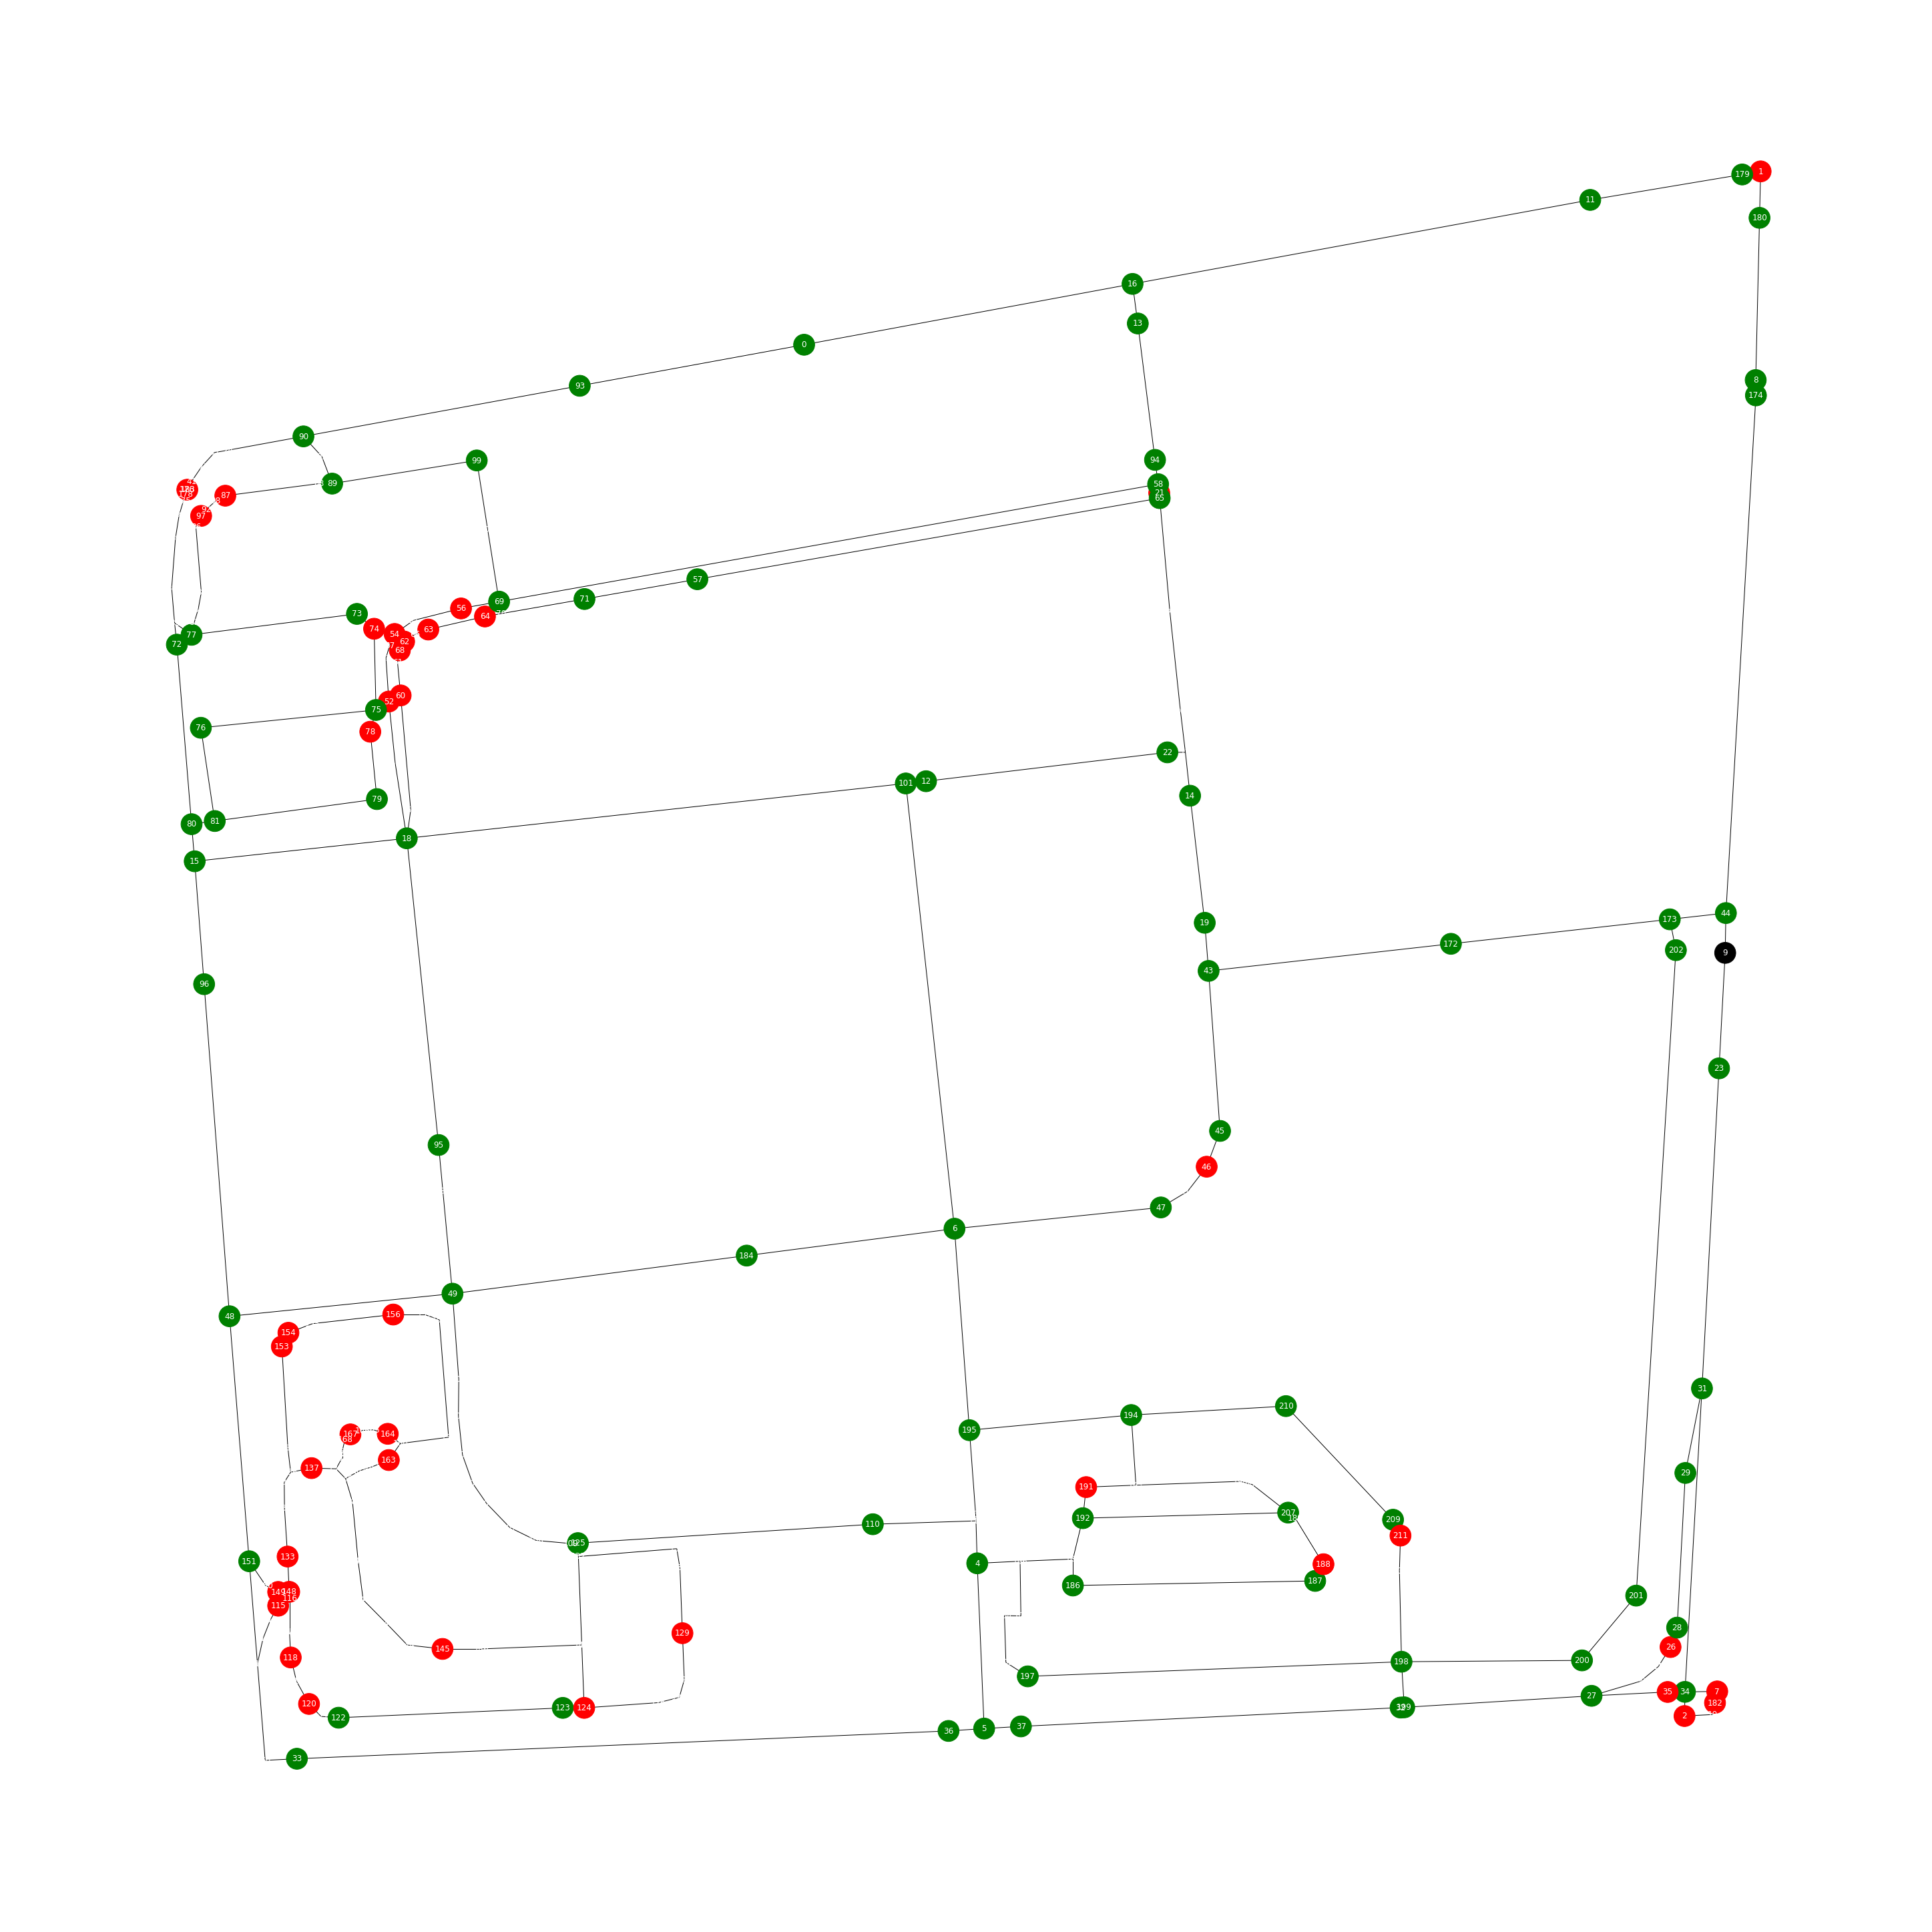

In [45]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (40, 40)  # 单位是inches
#green transit_node
#black depot_node
#red package node
#grey normal_node
nx.draw(TG, 
        pos=pos_location, 
        node_size=node_size_map, 
        cmap=plt.get_cmap('viridis'), 
        node_color=color_map, 
        width=1,
        with_labels=True, 
        font_color='white')

In [46]:
import heapq

class My_PriorityQueue(object):
    def __init__(self):
        self._queue = []
        self._index = 0

    def push(self, item, priority):
        """
        队列由 (priority, index, item) 形式组成
        priority 增加 "-" 号是因为 heappush 默认是最小堆
        index 是为了当两个对象的优先级一致时，按照插入顺序排列
        """
        heapq.heappush(self._queue, (priority, self._index, item))
        self._index += 1

    def pop(self):
        """
        弹出优先级最高的对象
        """
        return heapq.heappop(self._queue)[-1]

    def qsize(self):
        return len(self._queue)

    def empty(self):
        return True if not self._queue else False

In [47]:
import copy
class A(object):
    def __init__(self, node_id, time_cost, flight_cost, path):
        self.node_id = node_id
        self.time_cost = time_cost
        self.flight_cost = flight_cost
        self.path = path
    def __repr__(self):
        return "{0} -- {1}".format(self.node_id, self.time_cost)




def Astar(transit_network, depot_id, package_id, Max_flight):
    start_node = A(depot_id, 0, 0, [depot_id])
    pq = My_PriorityQueue()
    pq.push(start_node, start_node.time_cost + transit_network.edges[depot_id, package_id]['time'])
#     max_count = 0
    while not pq.empty():
#         if pq.qsize() > max_count:
#             max_count = pq.qsize()
#             print(max_count)
        cur = pq.pop()

        if(cur.node_id == package_id):
            print("path", cur.path)
            print("flight_cost",cur.flight_cost)
            return cur.time_cost, cur.path

        for neighbor, w in transit_network[cur.node_id].items():
            if cur.flight_cost + transit_network.edges[cur.node_id, neighbor]['weight'] < Max_flight:

                path = copy.deepcopy(cur.path)
                path.append(neighbor)

                if neighbor == package_id:
                    add_node = A(neighbor, cur.time_cost + transit_network.edges[cur.node_id, neighbor]['time'], cur.flight_cost + transit_network.edges[cur.node_id, neighbor]['weight'], path)
                    pq.push(add_node, add_node.time_cost)
                else:
                    add_node = A(neighbor, cur.time_cost + transit_network.edges[cur.node_id, neighbor]['time'], cur.flight_cost + transit_network.edges[cur.node_id, neighbor]['weight'], path)
                    pq.push(add_node, add_node.time_cost + transit_network.edges[neighbor, package_id]['time'])
    return -1

In [48]:
import MAPF.single_drone_FP
import MAPF.Astar
import main
imp.reload(MAPF.single_drone_FP)
imp.reload(MAPF.Astar)
imp.reload(main)

<module 'main' from '/Users/luzy6/PycharmProjects/UAV_mission_assignment_and_path_planning/main.py'>

In [49]:
depot_id = 9
package_id = 118
Max_flight = 150

In [20]:
transit_network = MAPF.single_drone_FP.generate_transit_network(TG, transit_node, transit_edges, depot_id, package_id)

In [21]:
success, sub_mission_way = MAPF.Astar.astar(transit_network, depot_id, package_id, Max_flight)

TypeError: __init__() missing 1 required positional argument: 'transit_wait'

In [20]:
sub_mission_way

[130, 6.0, 101.0, 14]

In [21]:
cur_time = 0
time_stamp = [0]
for i in range(len(sub_mission_way)-1):
    cur_time += transit_network.edges[sub_mission_way[i], sub_mission_way[i+1]]['time']
    time_stamp.append(cur_time)

In [22]:
transit_network.edges[6, 101]['type']

'transit'

In [23]:
time_stamp

[0, 10.718879808053215, 25.16522469284275, 32.322058478666065]

In [50]:
transit_constrain = {}
for transit in transit_node:
    transit_constrain[transit] = []

In [25]:
transit_constrain[6].append([10,12])

In [23]:
transit_constrain

{0.0: [],
 4.0: [],
 5.0: [],
 6.0: [],
 8.0: [],
 11.0: [],
 12.0: [],
 13.0: [],
 14.0: [],
 15.0: [],
 16.0: [],
 18.0: [],
 19.0: [],
 22.0: [],
 23.0: [],
 27.0: [],
 28.0: [],
 29.0: [],
 31.0: [],
 32.0: [],
 33.0: [],
 34.0: [],
 36.0: [],
 37.0: [],
 43.0: [],
 44.0: [],
 45.0: [],
 47.0: [],
 48.0: [],
 49.0: [],
 57.0: [],
 58.0: [],
 65.0: [],
 69.0: [],
 71.0: [],
 72.0: [],
 73.0: [],
 75.0: [],
 76.0: [],
 77.0: [],
 79.0: [],
 80.0: [],
 81.0: [],
 89.0: [],
 90.0: [],
 93.0: [],
 94.0: [],
 95.0: [],
 96.0: [],
 99.0: [],
 101.0: [],
 110.0: [],
 122.0: [],
 123.0: [],
 125.0: [],
 151.0: [],
 172.0: [],
 173.0: [],
 174.0: [],
 179.0: [],
 180.0: [],
 184.0: [],
 186.0: [],
 187.0: [],
 192.0: [],
 194.0: [],
 195.0: [],
 197.0: [],
 198.0: [],
 199.0: [],
 200.0: [],
 201.0: [],
 202.0: [],
 207.0: [],
 209.0: [],
 210.0: []}

In [51]:
depot_id = 9
package_id = 118

In [52]:
transit_network = MAPF.single_drone_FP.generate_transit_network(TG, transit_node, transit_edges, depot_id, package_id)

In [59]:
success, sub_mission_way, transit_wait = MAPF.Astar.astar_with_conflict_avoid(transit_network, transit_constrain, transit_edges, depot_id, package_id, Max_flight=100)

false plan by astar


In [57]:
transit_wait

{(58, 69): 3.9294037761699667,
 (69, 58): 3.9294037761699667,
 (33, 36): 2.5377860614848418,
 (36, 33): 2.5377860614848418,
 (201, 202): 2.4721879691071504,
 (202, 201): 2.4721879691071504,
 (18, 101): 2.4577309161842016,
 (101, 18): 2.4577309161842016,
 (44, 174): 2.290719578963478,
 (174, 44): 2.290719578963478,
 (57, 65): 0.5339622894503254,
 (65, 57): 0.5339622894503254,
 (11, 16): 0.7380576693059829,
 (16, 11): 0.7380576693059829,
 (6, 101): 2.3011476350691353,
 (101, 6): 2.3011476350691353,
 (32, 37): 2.2556338879489517,
 (37, 32): 2.2556338879489517,
 (197, 198): 1.4001927702179657,
 (198, 197): 1.4001927702179657,
 (0, 16): 1.5271852612057355,
 (16, 0): 1.5271852612057355,
 (48, 96): 0.48301202595044535,
 (96, 48): 0.48301202595044535,
 (23, 31): 0.6893206503725162,
 (31, 23): 0.6893206503725162,
 (18, 95): 0.04315638005193383,
 (95, 18): 0.04315638005193383,
 (49, 184): 1.3568989366613187,
 (184, 49): 1.3568989366613187,
 (110, 125): 1.0433625514938831,
 (125, 110): 1.04336255

In [32]:
sub_mission_way
# [130, 6.0, 101.0, 12.0, 22.0, 94]

[127, 49.0, 48.0, 96.0, 15.0, 80.0, 72.0, 77.0, 73.0, 55]

In [184]:
TG, depots_node, transit_node, packages_node, transit_edges, cost_matrix = graph.generate_graph.return_Digraph(N_depots,
                                                                                                N_transit_edges, N_packages)

In [185]:
def dist(a, b, TG=TG):
    lat1 = TG.nodes[a]['lat']
    lon1 = TG.nodes[a]['lon']
    lat2 = TG.nodes[b]['lat']
    lon2 = TG.nodes[b]['lon']
    #     print("node",a,lon1,lat1,"to node",b,lon2,lat2," liner distance:",haversine(lon1, lat1, lon2, lat2))
    #     print(haversine(lon1, lat1, lon2, lat2))
    #     print(lat1, lon1, lat2, lon2)
    return haversine(lon1, lat1, lon2, lat2)


# update other parameters
total_nodes = len(TG.nodes)
N_transits = len(transit_node)

# we get transit node, package node and depot node, now we store the rest nodes are normal node
normal_node = np.array([])
for i in range(len(TG.nodes())):
    if i not in depots_node and i not in transit_node and i not in packages_node:
        normal_node = np.append(normal_node, i)

print("do task allocation")

do task allocation


In [186]:
drone_tours = task_allocation_layer.task_allocation.task_allocation(total_nodes, N_depots, N_packages, N_drones,
                                                                        cost_matrix, depots_node, transit_node,
                                                                        packages_node, normal_node)

task allocation done


/Users/luzy6/PycharmProjects/UAV_mission_assignment_and_path_planning/task_allocation_layer/task_allocation.py:133: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  res = linprog(c=cost_vector, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
/Users/luzy6/miniforge3/envs/UAV/lib/python3.9/site-packages/scipy/optimize/_linprog_util.py:843: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  warn(redundancy_warning, OptimizeWarning, stacklevel=1)


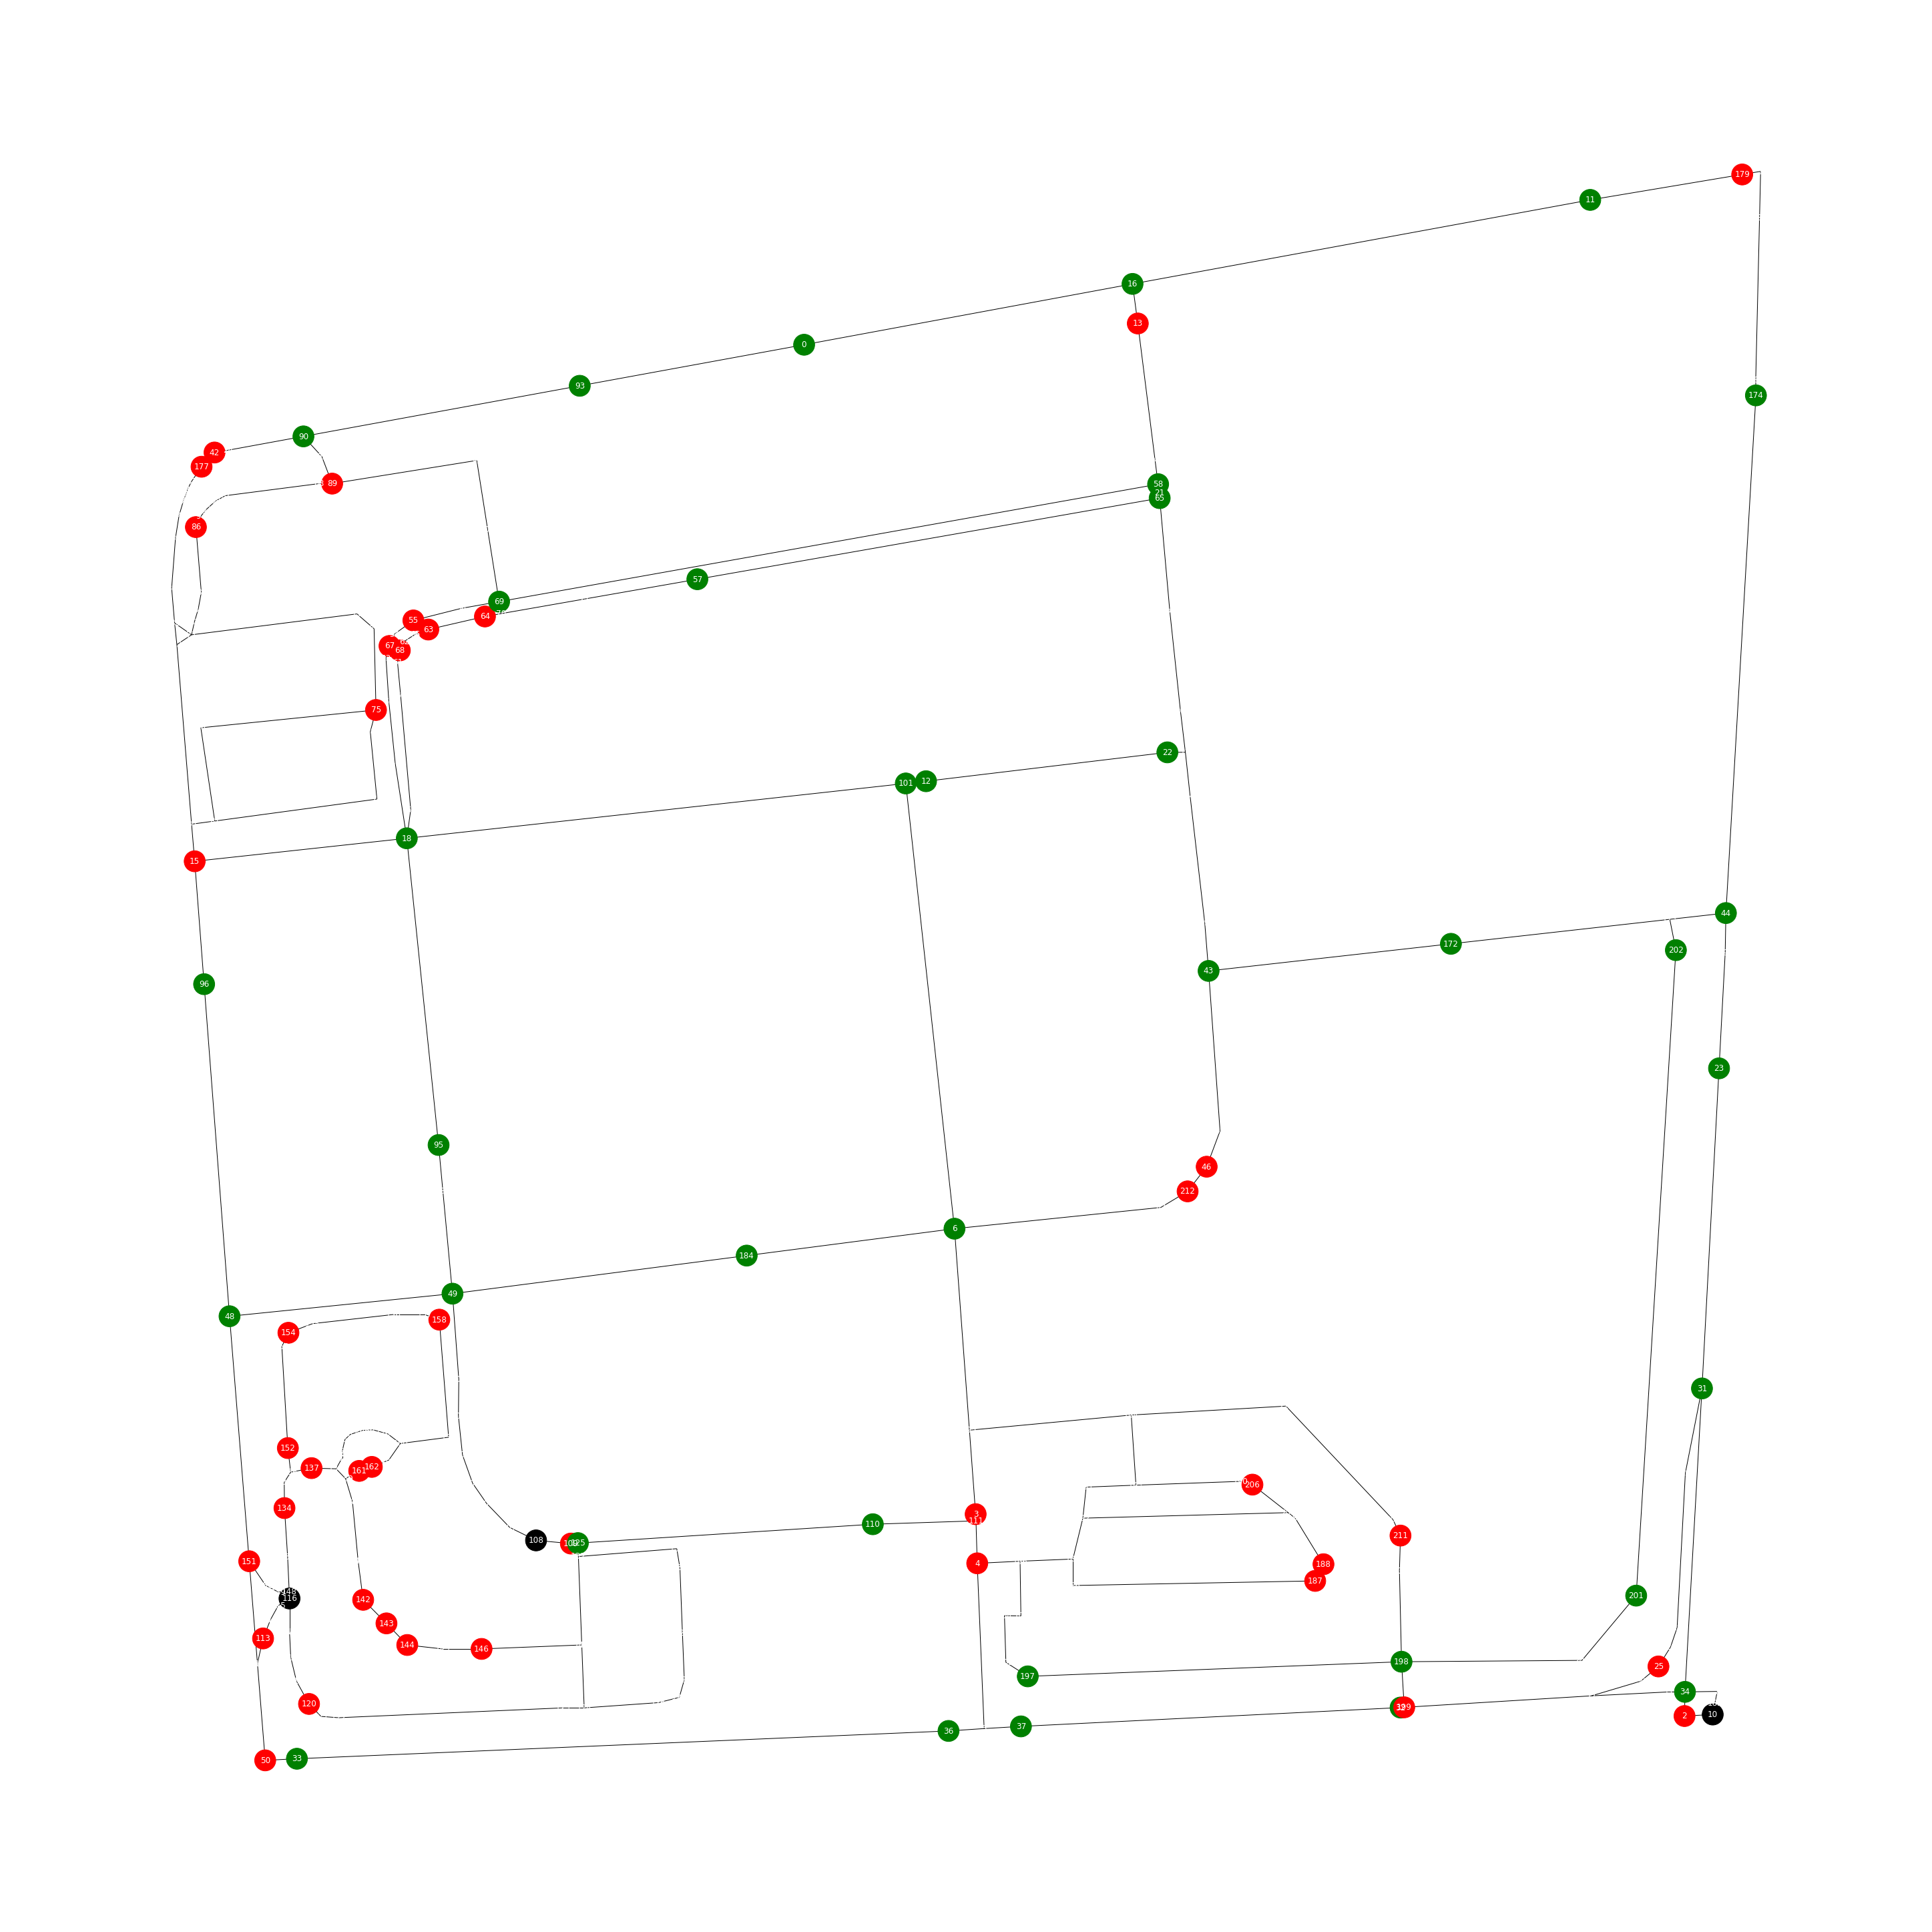

In [187]:
# find each drones route
drone_routes = []
for i in range(len(drone_tours)):
    cur_route = [drone_tours[i][0]]
    #     print("drone", i, "route:")
    for (node1, node2) in zip(drone_tours[i][:len(drone_tours[i]) - 1], drone_tours[i][1:]):
        cur_route.extend(nx.astar_path(TG, node1, node2, dist)[1:])
    #         print(nx.astar_path(TG, node1, node2, dist))
    drone_routes.append(cur_route)

pos_location = {}
for i in TG.nodes:
    pos_location[i] = (TG.nodes[i]['lon'], TG.nodes[i]['lat'])

node_size = 1000
colo_map = {}
nod_size_map = {}
for i in transit_node:
    colo_map[i] = 'green'
    nod_size_map[i] = node_size
for i in packages_node:
    colo_map[i] = 'red'
    nod_size_map[i] = node_size
for i in depots_node:
    colo_map[i] = 'black'
    nod_size_map[i] = node_size
for i in normal_node:
    colo_map[i] = 'grey'
    nod_size_map[i] = 0
len(colo_map)
color_map = []
node_size_map = []
for i in range(len(colo_map)):
    color_map.append(colo_map[i])
    node_size_map.append(nod_size_map[i])

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (40, 40)  # 单位是inches
# green transit_node
# black depot_node
# red package node
# grey normal_node
nx.draw(TG,
        pos=pos_location,
        node_size=node_size_map,
        cmap=plt.get_cmap('viridis'),
        node_color=color_map,
        width=1,
        with_labels=True,
        font_color='white')
fig_name = 'bicycle_map.jpg'
plt.savefig(fig_name, dpi=200)
# plt.show()

drone_one_dilivery_route = []
drone_one_dilivery_time_stamp = []
drone_one_dilivery_time = []
fail_packages = []

In [247]:
imp.reload(main)
# imp.reload(MAPF.Astar)
transit_constrain = {}
for transit in transit_node:
    transit_constrain[transit] = []
# 我们现在只算每个无人机第一个任务路径
for i in range(len(drone_tours)):
    start_depot, package = drone_tours[i][0:2]
    success, departure_route, departure_time_stamp, departure_time = main.one_drone_dilivery_departure_route_by_astar(TG, transit_constrain, transit_node, transit_edges, start_depot, package, Max_flight)
    if success:
        drone_one_dilivery_route.append(departure_route)
        drone_one_dilivery_time_stamp.append(departure_time_stamp)
        drone_one_dilivery_time.append(departure_time)
    else:
        if package in packages_node:
            fail_packages.append(package)
        drone_one_dilivery_route.append([])
        drone_one_dilivery_time_stamp.append([0])
        drone_one_dilivery_time.append(-1) # denote fail

10.0  to 2.0 route_plan_distance_cost 14.199932305908066
route: [10.0, 2.0]
use time 0.7099966152954033
108.0  to 3.0 route_plan_distance_cost 221.51650918755544
route: [108.0, 3.0]
use time 11.075825459377771
108.0  to 46.0 route_plan_distance_cost 382.72352666852674
route: [108.0, 46.0]
use time 19.136176333426338
108.0  to 64.0 route_plan_distance_cost 311.63579352252054
route: [108.0, 95.0, 18.0, 64.0]
use time 27.01973961950894
108.0  to 109.0 route_plan_distance_cost 17.591761912802927
route: [108.0, 109.0]
use time 0.8795880956401463
108.0  to 212.0 route_plan_distance_cost 368.68440101645416
route: [108.0, 212.0]
use time 18.43422005082271
116.0  to 50.0 route_plan_distance_cost 79.21909125014623
route: [116.0, 50.0]
use time 3.960954562507312
116.0  to 113.0 route_plan_distance_cost 23.454044443311197
route: [116.0, 113.0]
use time 1.1727022221655599


In [248]:
transit_constrain

{0.0: [],
 6.0: [],
 11.0: [],
 12.0: [],
 16.0: [],
 18.0: [],
 22.0: [],
 23.0: [],
 31.0: [],
 32.0: [],
 33.0: [],
 34.0: [],
 36.0: [],
 37.0: [],
 43.0: [],
 44.0: [],
 48.0: [],
 49.0: [],
 57.0: [],
 58.0: [],
 65.0: [],
 69.0: [],
 90.0: [],
 93.0: [],
 95.0: [[9.869351423363891, 11.361804705255523]],
 96.0: [],
 101.0: [],
 110.0: [],
 125.0: [],
 172.0: [],
 174.0: [],
 184.0: [],
 197.0: [],
 198.0: [],
 201.0: [],
 202.0: []}

In [249]:
print(drone_one_dilivery_route)
print(drone_one_dilivery_time_stamp)
print(drone_one_dilivery_time)
print(fail_packages)

[[10.0, 2.0], [108.0, 3.0], [108.0, 46.0], [108.0, 95.0, 18.0, 64.0], [108.0, 109.0], [108.0, 212.0], [116.0, 50.0], [116.0, 113.0], [10.0, 2.0], [108.0, 3.0], [108.0, 46.0], [108.0, 95.0, 18.0, 64.0], [108.0, 109.0], [108.0, 212.0], [116.0, 50.0], [116.0, 113.0], [10.0, 2.0], [108.0, 3.0], [108.0, 46.0], [108.0, 95.0, 18.0, 64.0], [108.0, 109.0], [108.0, 212.0], [116.0, 50.0], [116.0, 113.0], [10.0, 2.0], [108.0, 3.0], [108.0, 46.0], [108.0, 95.0, 18.0, 64.0], [108.0, 109.0], [108.0, 212.0], [116.0, 50.0], [116.0, 113.0], [10.0, 2.0], [108.0, 3.0], [108.0, 46.0], [108.0, 95.0, 18.0, 64.0], [108.0, 109.0], [108.0, 212.0], [116.0, 50.0], [116.0, 113.0], [10.0, 2.0], [108.0, 3.0], [108.0, 46.0], [108.0, 95.0, 18.0, 64.0], [108.0, 109.0], [108.0, 212.0], [116.0, 50.0], [116.0, 113.0], [10.0, 2.0], [108.0, 3.0], [108.0, 46.0], [108.0, 95.0, 18.0, 64.0], [108.0, 109.0], [108.0, 212.0], [116.0, 50.0], [116.0, 113.0], [10.0, 2.0], [108.0, 3.0], [108.0, 46.0], [108.0, 95.0, 18.0, 64.0], [108.0

In [257]:
imp.reload(MAPF.Astar)
main.one_drone_dilivery_departure_route_by_astar(TG, transit_constrain, transit_node, transit_edges, 108, 55, Max_flight)

108  to 55 route_plan_distance_cost 302.7963122128307
route: [108, 95.0, 18.0, 55]
use time 26.937200891195392


(True,
 [108, 95.0, 18.0, 55],
 [0.0, 9.869351423363891, 21.66673670391775, 26.937200891195392],
 26.937200891195392)

In [258]:
transit_constrain

{0.0: [],
 6.0: [],
 11.0: [],
 12.0: [],
 16.0: [],
 18.0: [],
 22.0: [],
 23.0: [],
 31.0: [],
 32.0: [],
 33.0: [],
 34.0: [],
 36.0: [],
 37.0: [],
 43.0: [],
 44.0: [],
 48.0: [],
 49.0: [],
 57.0: [],
 58.0: [],
 65.0: [],
 69.0: [],
 90.0: [],
 93.0: [],
 95.0: [[9.869351423363891, 11.72124004242647]],
 96.0: [],
 101.0: [],
 110.0: [],
 125.0: [],
 172.0: [],
 174.0: [],
 184.0: [],
 197.0: [],
 198.0: [],
 201.0: [],
 202.0: []}

In [252]:
class Solution:
    def insert(intervals, newInterval):
        left, right = newInterval
        placed = False
        ans = list()
        for li, ri in intervals:
            if li > right:
                # 在插入区间的右侧且无交集
                if not placed:
                    ans.append([left, right])
                    placed = True
                ans.append([li, ri])
            elif ri < left:
                # 在插入区间的左侧且无交集
                ans.append([li, ri])
            else:
                # 与插入区间有交集，计算它们的并集
                left = min(left, li)
                right = max(right, ri)
        
        if not placed:
            ans.append([left, right])
        return ans


In [261]:
total_task = 0
for tour in drone_tours:
    total_task += len(tour) - 1

In [264]:
drone_tours

[[10.0, 2.0, 10.0, 25.0, 10.0, 179.0, 10.0, 199.0, 10.0, 211.0, 10.0],
 [108.0, 3.0, 108.0, 4.0, 108.0, 13.0, 108.0],
 [108.0, 46.0, 108.0, 55.0, 108.0, 63.0, 108.0],
 [108.0, 64.0, 108.0, 67.0, 108.0, 68.0, 108.0],
 [108.0,
  109.0,
  108.0,
  144.0,
  108.0,
  146.0,
  108.0,
  187.0,
  108.0,
  188.0,
  108.0,
  206.0,
  108.0],
 [108.0, 212.0, 108.0, 116.0, 15.0, 116.0, 42.0, 116.0],
 [116.0, 50.0, 116.0, 75.0, 116.0, 86.0, 116.0, 89.0, 116.0],
 [116.0,
  113.0,
  116.0,
  120.0,
  116.0,
  134.0,
  116.0,
  137.0,
  116.0,
  142.0,
  116.0,
  143.0,
  116.0,
  151.0,
  116.0,
  152.0,
  116.0,
  154.0,
  116.0,
  158.0,
  116.0,
  161.0,
  116.0,
  162.0,
  116.0,
  177.0,
  116.0]]

In [271]:
imp.reload(MAPF.Astar)
imp.reload(main)
task_plan = 0
index = 0
drone_route_plans = [[] for _ in range(len(drone_tours))]
drone_route_time_stamp = [[] for _ in range(len(drone_tours))]
drone_start_time = [0 for _ in range(len(drone_tours))]
while task_plan < total_task:
    for i in range(len(drone_tours)):
        if index + 1 >= len(drone_tours[i]):
            continue
        start, end = drone_tours[i][index], drone_tours[i][index+1]
        success, departure_route, departure_time_stamp, departure_time = main.one_drone_dilivery_departure_route_by_astar(
            TG, transit_constrain, transit_node, transit_edges, start, end, Max_flight, drone_start_time[i])
#         print(drone_tours[i][index], drone_tours[i][index+1])
        if success:
            drone_route_plans[i].append(departure_route)
            drone_route_time_stamp[i].append(departure_time_stamp)
            drone_start_time[i] = departure_time_stamp[-1]
        else:
            drone_route_plans[i].append([])
            drone_route_time_stamp[i].append([0])
        task_plan += 1
    index += 1
        
        
    

KeyboardInterrupt: 

In [ ]:
drone_route_plans

In [ ]:
drone_route_time_stamp